# Курсовой проект для курса "Python для Data Science"

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Материалы к проекту (файлы):
train.csv
test.csv

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn import preprocessing
from sklearn import utils

warnings.filterwarnings('ignore')
%matplotlib inline
# svg не подключаем, так как система не справляется с таким болшим количеством векторной графики.

In [2]:
TRAIN_DATASET_PATH = 'train.csv'

In [3]:
TEST_DATASET_PATH = 'test.csv'

### Загрузка данных

**Описание датасета:**
* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH)
train.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751            6.0      7   
1  15053          41    3.0  65.683640   40.049543            8.0      7   
2   4765          53    2.0  44.947953   29.197612            0.0      8   
3   5809          58    2.0  53.352981   52.731512            9.0      8   
4  10783          99    1.0  39.649192   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1969   0.089040         B         B        33      7976   
1         9.0       1978   0.000070         B         B        46     10309   
2        12.0       1968   0.049637         B         B        34      7759   
3        17.0       1977   0.437885         B         B        23      5735   
4        12.0       1976   0.012339         B         B        35      5776   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         5           NaN            0       11       B  184966.930730  
1         1         240.0            1       16       B  300009.450063  
2         0         229.0            1        3       B  220925.908524  
3         3        1084.0            0        5       B  175616.227217  
4         1        2078.0            2        4       B  150226.531644

In [5]:
test = pd.read_csv(TEST_DATASET_PATH)
test.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0    725          58    2.0  49.882643   33.432782            6.0      6   
1  15856          74    2.0  69.263183         NaN            1.0      6   
2   5480         190    1.0  13.597819   15.948246           12.0      2   
3  15664          47    2.0  73.046609   51.940842            9.0     22   
4  14275          27    1.0  47.527111   43.387569            1.0     17   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        14.0       1972   0.310199         B         B        11      2748   
1         1.0       1977   0.075779         B         B         6      1437   
2         5.0       1909   0.000000         B         B        30      7538   
3        22.0       2007   0.101872         B         B        23      4583   
4        17.0       2017   0.072158         B         B         2       629   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
0         1           NaN            0        0       B  
1         3           NaN            0        2       B  
2        87        4702.0            5        5       B  
3         3           NaN            3        3       B  
4         1           NaN            0        0       A

### Приведение типов данных

### Тренировочный набор

In [6]:
train.shape

(10000, 20)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [8]:
train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Количество комнат должно быть целым числом.

In [9]:
train['Rooms'].dtype

dtype('float64')

In [10]:
train['Rooms'] = train['Rooms'].astype('int64')

In [11]:
train['Rooms'].dtype

dtype('int64')

Количество этажей целочисленное значение.

In [12]:
train['HouseFloor'].dtype

dtype('float64')

In [13]:
train['HouseFloor'] = train['HouseFloor'].astype('int64')

In [14]:
train['HouseFloor'].dtype

dtype('int64')

Площадь кухни по факту есть целочисленное значение, что ни есть целочисленное значение, то есть выброс.

In [15]:
train['KitchenSquare'].dtype

dtype('float64')

In [16]:
train['KitchenSquare'] = train['KitchenSquare'].astype('int64')

In [17]:
train['KitchenSquare'].dtype

dtype('int64')

### Тестовый набор

In [18]:
test.shape

(5000, 19)

In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


In [20]:
test.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

Количество комнат должно быть целым числом.

In [21]:
test['Rooms'].dtype

dtype('float64')

In [22]:
test['Rooms'] = test['Rooms'].astype('int64')

In [23]:
test['Rooms'].dtype

dtype('int64')

Количество этажей целочисленное значение.

In [24]:
test['HouseFloor'].dtype

dtype('float64')

In [25]:
test['HouseFloor'] = test['HouseFloor'].astype('int64')

In [26]:
test['HouseFloor'].dtype

dtype('int64')

Площадь кухни по факту есть целочисленное значение, что ни есть целочисленное значение, то есть выброс.

In [27]:
test['KitchenSquare'].dtype

dtype('float64')

In [28]:
test['KitchenSquare'] = test['KitchenSquare'].astype('int64')

In [29]:
test['KitchenSquare'].dtype

dtype('int64')

Объединим оба набора для вычищения данных.

In [30]:
df = pd.concat((train, test), sort=False).reset_index(drop=True)

In [31]:
df.shape

(15000, 20)

### Статистика

In [32]:
df.describe()

Id    DistrictId         Rooms        Square    LifeSquare  \
count  15000.000000  15000.000000  15000.000000  15000.000000  11846.000000   
mean    8393.136933     50.693600      1.897000     56.360350     36.851792   
std     4850.111673     43.786257      0.839229     20.423913     71.120183   
min        0.000000      0.000000      0.000000      1.136859      0.333490   
25%     4188.750000     20.000000      1.000000     41.814371     22.896130   
50%     8378.500000     37.000000      2.000000     52.645757     32.822810   
75%    12594.250000     75.000000      2.000000     66.036608     45.144624   
max    16798.000000    212.000000     19.000000    641.065193   7480.592129   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   15000.000000  15000.000000  15000.000000  1.500000e+04  15000.000000   
mean        6.174467      8.561800     12.606600  3.321575e+03      0.119196   
std        24.016979      5.323113      6.780165  1.637078e+05      0.119371   
min         0.000000      1.000000      0.000000  1.908000e+03      0.000000   
25%         1.000000      4.000000      9.000000  1.974000e+03      0.017647   
50%         6.000000      7.000000     12.000000  1.977000e+03      0.075424   
75%         9.000000     12.000000     17.000000  2.001000e+03      0.195781   
max      2014.000000     78.000000    117.000000  2.005201e+07      0.521867   

           Social_1      Social_2      Social_3  Healthcare_1   Helthcare_2  \
count  15000.000000  15000.000000  15000.000000   7825.000000  15000.000000   
mean      24.769267   5370.404933      8.113667   1144.162428      1.319467   
std       17.532278   4013.364403     23.841946   1029.296278      1.489012   
min        0.000000    168.000000      0.000000      0.000000      0.000000   
25%        6.000000   1564.000000      0.000000    350.000000      0.000000   
50%       25.000000   5285.000000      2.000000    900.000000      1.000000   
75%       36.000000   7287.000000      5.000000   1548.000000      2.000000   
max       74.000000  19083.000000    141.000000   4849.000000      6.000000   

            Shops_1          Price  
count  15000.000000   10000.000000  
mean       4.235133  214138.857399  
std        4.796545   92872.293865  
min        0.000000   59174.778028  
25%        1.000000  153872.633942  
50%        3.000000  192269.644879  
75%        6.000000  249135.462171  
max       23.000000  633233.466570

### Обзор количественных переменных

In [33]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])
df_num_features.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35      2  47.981561   29.442751              6      7   
1  15053          41      3  65.683640   40.049543              8      7   
2   4765          53      2  44.947953   29.197612              0      8   
3   5809          58      2  53.352981   52.731512              9      8   
4  10783          99      1  39.649192   23.776169              7     11   

   HouseFloor  HouseYear  Ecology_1  Social_1  Social_2  Social_3  \
0           9       1969   0.089040        33      7976         5   
1           9       1978   0.000070        46     10309         1   
2          12       1968   0.049637        34      7759         0   
3          17       1977   0.437885        23      5735         3   
4          12       1976   0.012339        35      5776         1   

   Healthcare_1  Helthcare_2  Shops_1          Price  
0           NaN            0       11  184966.930730  
1         240.0            1       16  300009.450063  
2         229.0            1        3  220925.908524  
3        1084.0            0        5  175616.227217  
4        2078.0            2        4  150226.531644

### Обзор номинативных переменных

In [34]:
df_obj_features = df.select_dtypes(include='object')
df_obj_features.head()

Ecology_2 Ecology_3 Shops_2
0         B         B       B
1         B         B       B
2         B         B       B
3         B         B       B
4         B         B       B

In [35]:
df['Ecology_2'].value_counts()

B    14855
A      145
Name: Ecology_2, dtype: int64

In [36]:
df['Ecology_3'].value_counts()

B    14576
A      424
Name: Ecology_3, dtype: int64

In [37]:
df['Shops_2'].value_counts()

B    13763
A     1237
Name: Shops_2, dtype: int64

### Обработка пропусков

In [38]:
len(df) - df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       3154
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     7175
Helthcare_2         0
Shops_1             0
Shops_2             0
Price            5000
dtype: int64

**LifeSquare**

Поскольку пустых значений слишком много, то рассмотрим их в зависимости от срезов по количеству комнат и по годам и заполним значениями медианы по этим срезам.

In [39]:
df['Rooms'][df['LifeSquare'].isnull()].value_counts()

1    1285
2    1271
3     577
4      15
0       3
5       2
6       1
Name: Rooms, dtype: int64

In [40]:
df['HouseYear'][df['LifeSquare'].isnull()].value_counts()

1977    2757
2016     102
2015      89
2017      87
2014      62
2018      33
2013      11
2019      10
2020       2
2012       1
Name: HouseYear, dtype: int64

In [41]:
for room in df['Rooms'][df['LifeSquare'].isnull()].unique():
    for year in df['HouseYear'][df['LifeSquare'].isnull()].unique():
        df.loc[df['LifeSquare'].isnull() & (df['Rooms'] == room) & (df['HouseYear'] == year), 'LifeSquare'] = df['LifeSquare'][df['LifeSquare'].notnull() & (df['Rooms'] == room) & (df['HouseYear'] == year)].median()

In [42]:
df.loc[df['LifeSquare'].isnull()]

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
3911     770          28      0   49.483501         NaN              0     16   
12071  10793          23      6  110.750226         NaN              0      2   

       HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
3911            0       2015   0.118537         B         B        30   
12071           2       2015   0.014073         B         B         2   

       Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
3911       6207         1        1183.0            1        0       B   
12071       475         0           NaN            0        0       B   

               Price  
3911   217009.338463  
12071            NaN

Заполним оставшееся пустое значение в зависимости от среза по площади.

In [43]:
df.loc[df['Id'] == 770, 'LifeSquare'] = df.loc[df['Square'].between(49.0, 50.0), 'Rooms'].median()

In [44]:
df.loc[df['Id'] == 10793, 'LifeSquare'] = df.loc[df['Square'].between(100.0, 120.0), 'Rooms'].median()

**Healthcare_1**

"Раскидаем" пустые значения по имеющимся классам значений

Получим уникальные значения из выборки

In [45]:
values = list(df.loc[df['Healthcare_1'].notnull(), 'Healthcare_1'].unique())

In [46]:
values = sorted(values)

In [47]:
length = len(values)

In [48]:
length

79

In [49]:
values[:5]

[0.0, 30.0, 32.0, 35.0, 46.0]

In [50]:
values[length - 5:]

[4087.0, 4129.0, 4508.0, 4702.0, 4849.0]

In [51]:
b = df.loc[df['Healthcare_1'].isnull()]

In [52]:
for id in b['Id']:
    df.loc[df['Id'] == id, 'Healthcare_1'] = values[random.randint(0, length - 1)]

**Ecology_2**

In [53]:
df['Ecology_2'].mode()[0]

'B'

In [54]:
df.replace({'Ecology_2': {'-':df['Ecology_2'].mode()[0]}}, inplace=True)

In [55]:
df['Ecology_2'].value_counts()

B    14855
A      145
Name: Ecology_2, dtype: int64

**Ecology_3**

In [56]:
df['Ecology_3'].mode()[0]

'B'

In [57]:
df.replace({'Ecology_3': {'-':df['Ecology_3'].mode()[0]}}, inplace=True)

In [58]:
df['Ecology_3'].value_counts()

B    14576
A      424
Name: Ecology_3, dtype: int64

**Shops_2**

In [59]:
df['Shops_2'].mode()[0]

'B'

In [60]:
df.replace({'Shops_2': {'-':df['Shops_2'].mode()[0]}}, inplace=True)

In [61]:
df['Shops_2'].value_counts()

B    13763
A     1237
Name: Shops_2, dtype: int64

### Обработка выбросов

### Отбор и построение новых признаков

In [62]:
df.sort_values(by="Id", inplace=True)

In [63]:
df = pd.concat([df, pd.get_dummies(df['Ecology_2'], prefix='Ecology_2')], axis=1)

In [64]:
df = pd.concat([df, pd.get_dummies(df['Ecology_3'], prefix='Ecology_3')], axis=1)

In [65]:
df = pd.concat([df, pd.get_dummies(df['Shops_2'], prefix='Shops_2')], axis=1)

In [66]:
# df.drop(['Id'],axis=1,inplace=True)

In [67]:
df.drop(['Ecology_2'],axis=1,inplace=True)

In [68]:
df.drop(['Ecology_3'],axis=1,inplace=True)

In [69]:
df.drop(['Shops_2'],axis=1,inplace=True)

In [70]:
df.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
7885    0           0      1  109.144492   84.613939             15      6   
14422   1           1      2   83.061098   83.830248              0     10   
5549    2           2      1   34.472263   16.069376              5      5   
10979   3           3      1   30.185483   14.810573              6      4   
14157   4           4      1   37.294669   17.165597              8      9   

       HouseFloor  HouseYear  Ecology_1  ...  Healthcare_1  Helthcare_2  \
7885           15       2011   0.319809  ...        2857.0            5   
14422          22       1977   0.007122  ...        1937.0            0   
5549           18       1969   0.000000  ...         645.0            2   
10979           9       1970   0.265089  ...        1937.0            3   
14157           9       1970   0.327018  ...        2500.0            1   

       Shops_1          Price  Ecology_2_A  Ecology_2_B  Ecology_3_A  \
7885         8  289034.391871            0            1            0   
14422        1            NaN            0            1            0   
5549         5  174548.966339            0            1            0   
10979        2            NaN            0            1            0   
14157        0            NaN            0            1            0   

       Ecology_3_B  Shops_2_A  Shops_2_B  
7885             1          0          1  
14422            1          0          1  
5549             1          0          1  
10979            1          0          1  
14157            1          0          1  

[5 rows x 23 columns]

Разобъем обратно набор данных df на 2 набора: тренировочный м икчирвый.

In [71]:
df_train = df.loc[df['Price'].notnull()]

In [72]:
df_test = df.loc[df['Price'].isnull()]

Сохраним эти наборы.

In [73]:
DF_TRAIN_DATASET_PATH = 'df_train.csv'

In [74]:
DF_TEST_DATASET_PATH = 'df_test.csv'

In [75]:
df_train.to_csv(DF_TRAIN_DATASET_PATH, index=False, encoding='utf-8')

In [76]:
df_test.to_csv(DF_TEST_DATASET_PATH, index=False, encoding='utf-8')

### Анализ целевой переменной

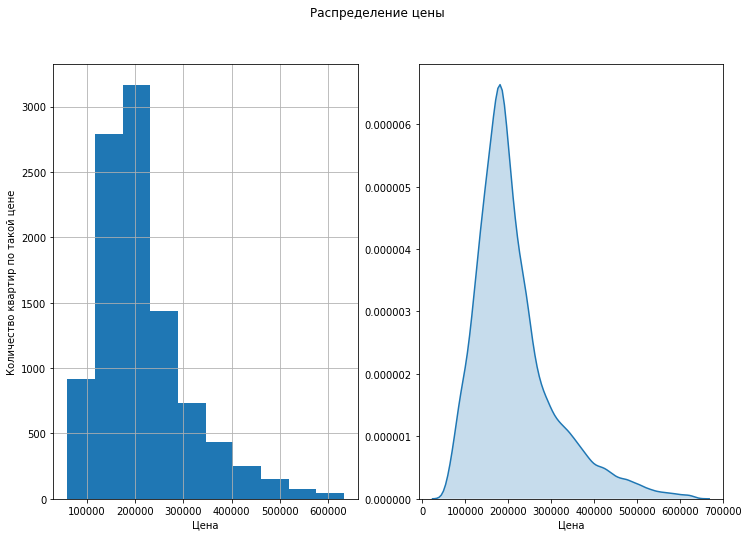

In [77]:
plt.figure(figsize = (12, 8))

plt.subplot(121)
df_train['Price'].hist()
plt.ylabel('Количество квартир по такой цене')
plt.xlabel('Цена')

plt.subplot(122)
sns.kdeplot(df_train['Price'], shade=True, legend=False)
plt.xlabel('Цена')

plt.suptitle('Распределение цены')
plt.show()

Почти идеальное нормальное распределение.

In [78]:
target_mean = round(df_train['Price'].mean(), 2)
target_median = df_train['Price'].median()
target_mode = df_train['Price'].mode()[0]

target_mean, target_median, target_mode

(214138.86, 192269.64487934904, 59174.77802758122)

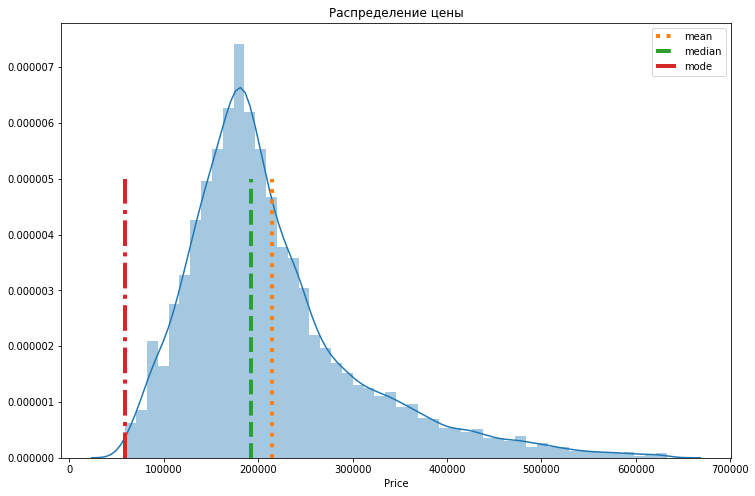

In [79]:
plt.figure(figsize = (12, 8))

sns.distplot(df_train['Price'])

y = np.linspace(0, 0.000005, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Распределение цены')
plt.legend()
plt.show()

### Анализ признаков

In [80]:
df_num_features = df_train.select_dtypes(include=['float64', 'int64'])

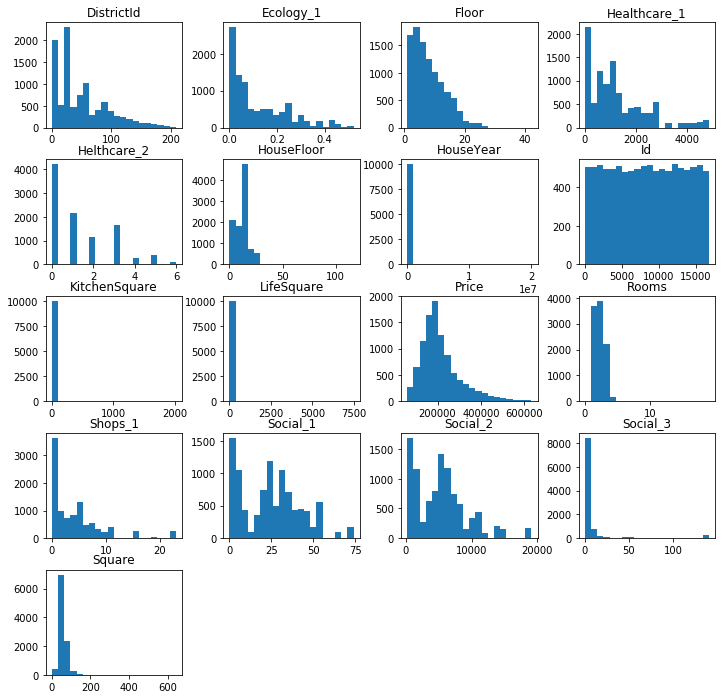

In [81]:
df_num_features.hist(figsize=(12,12), bins=20, grid=False);

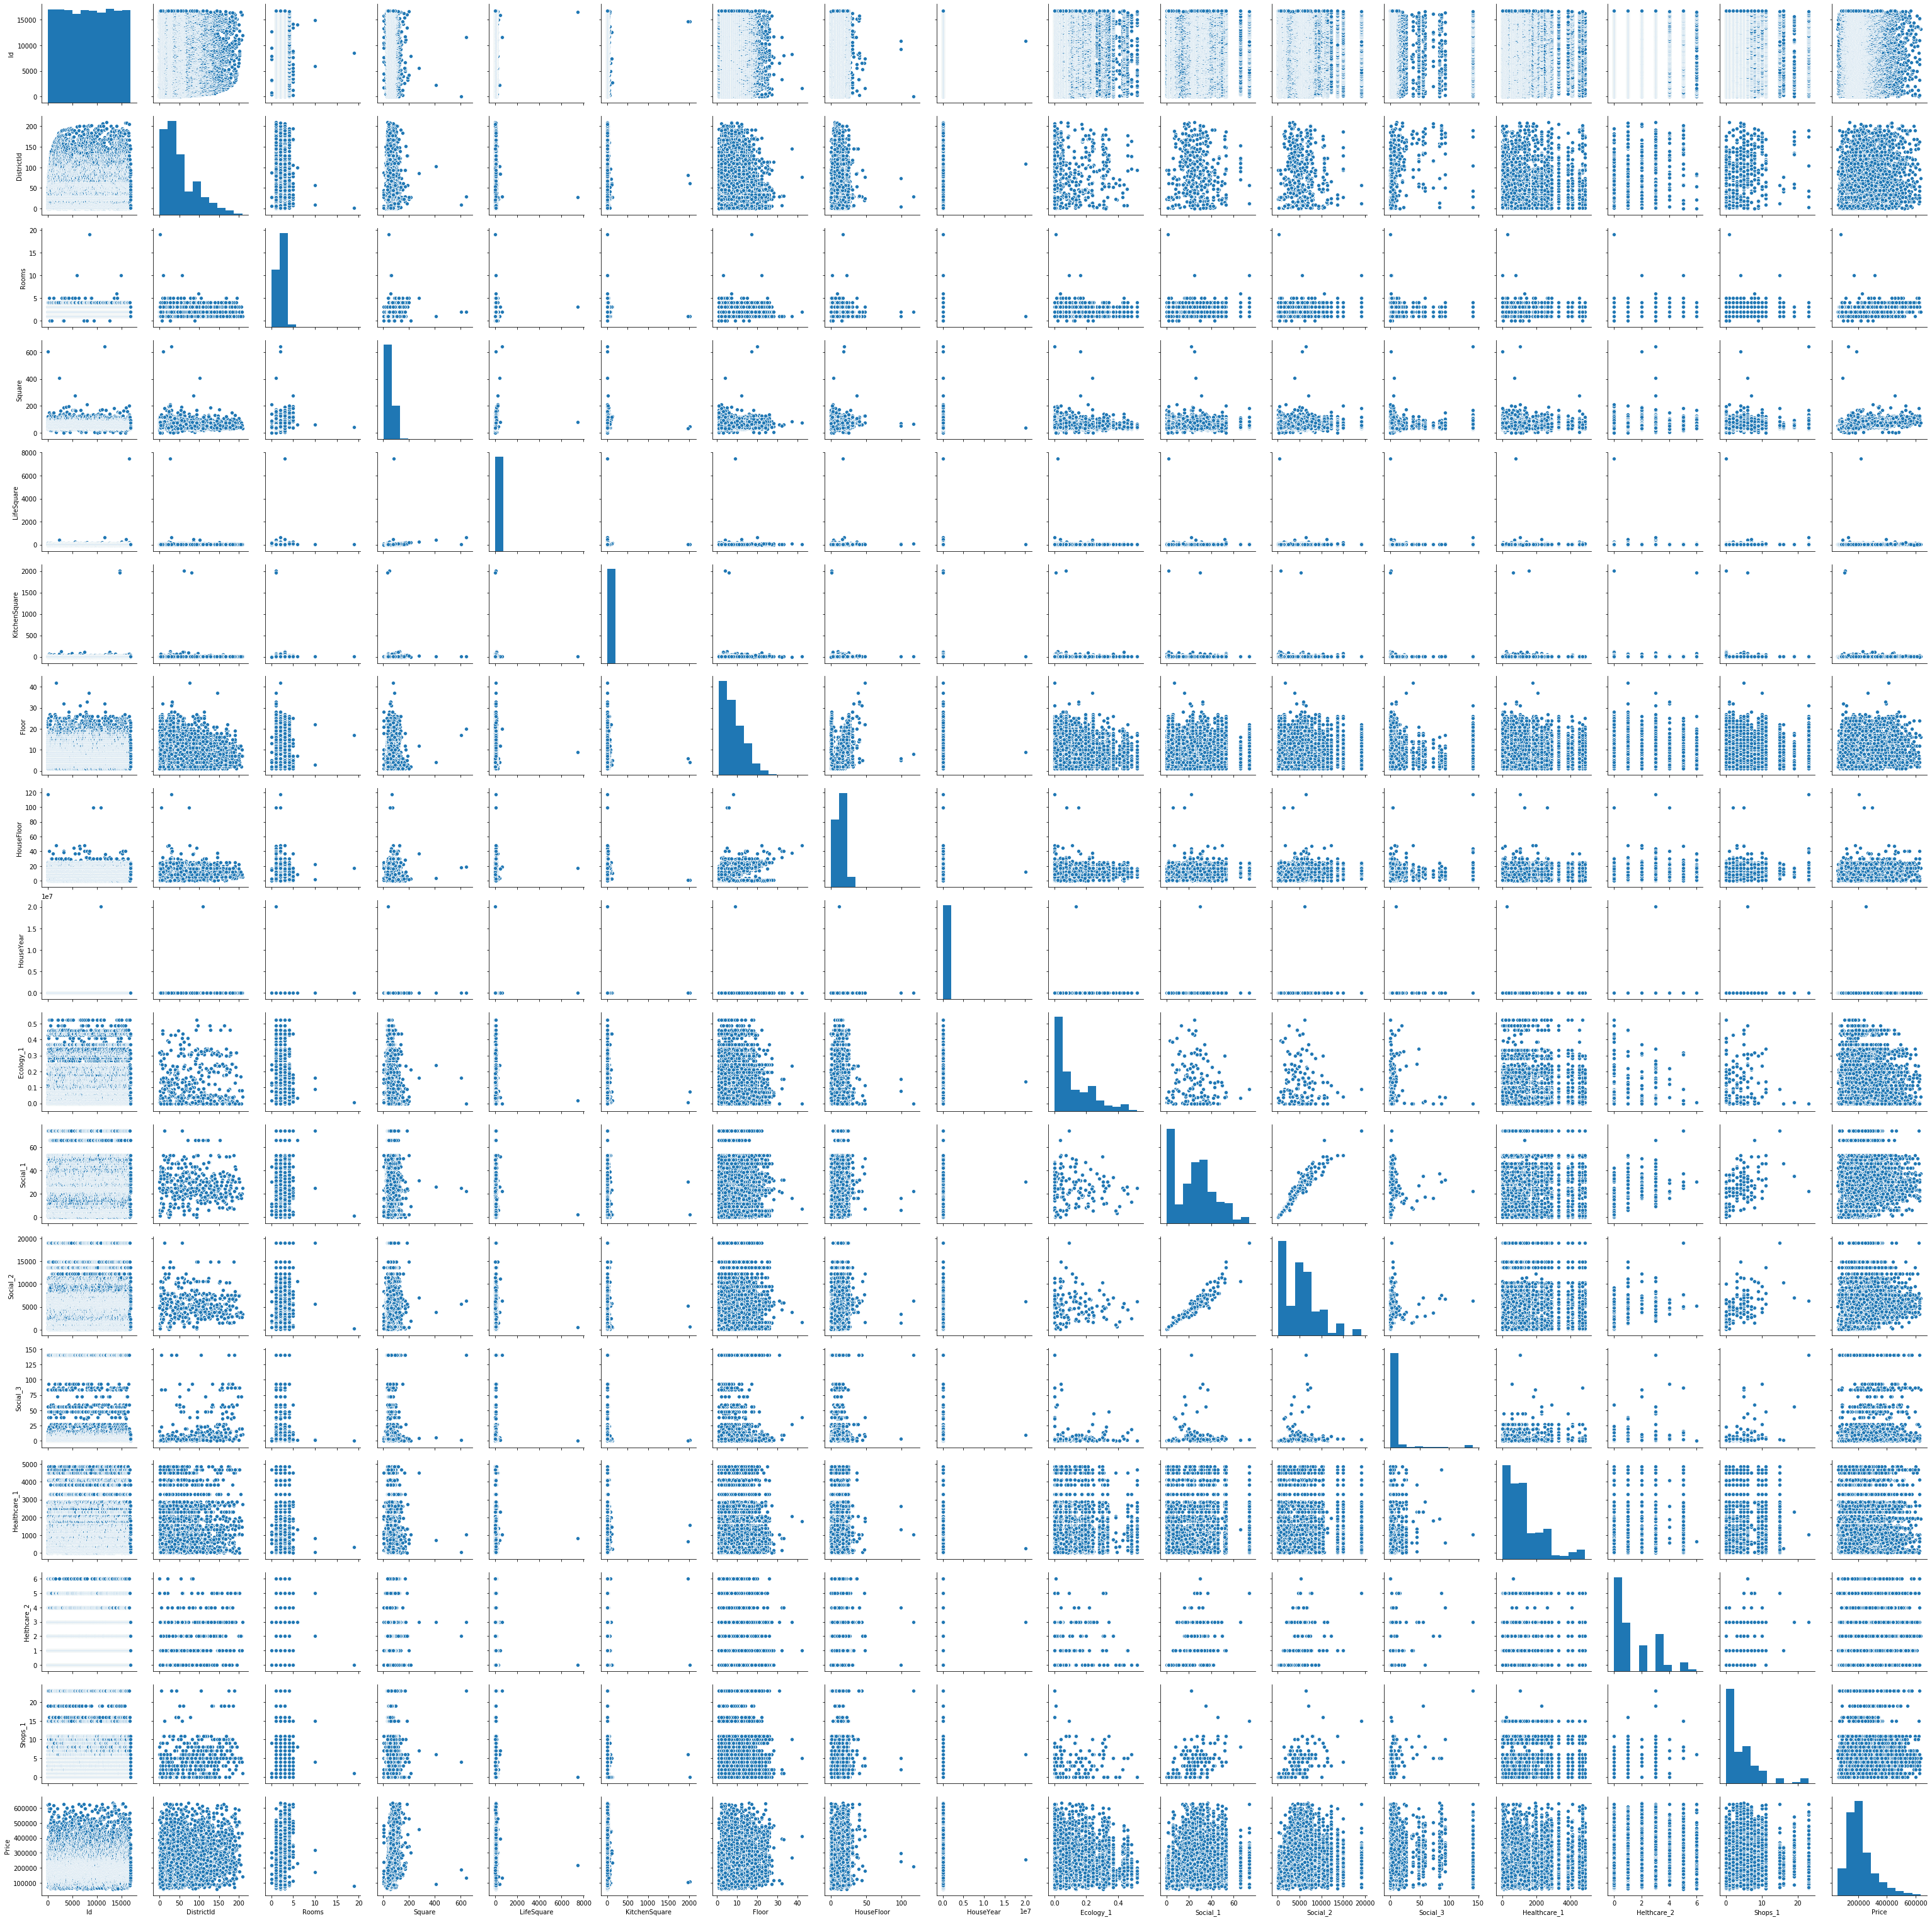

In [82]:
sns.pairplot(df_num_features);

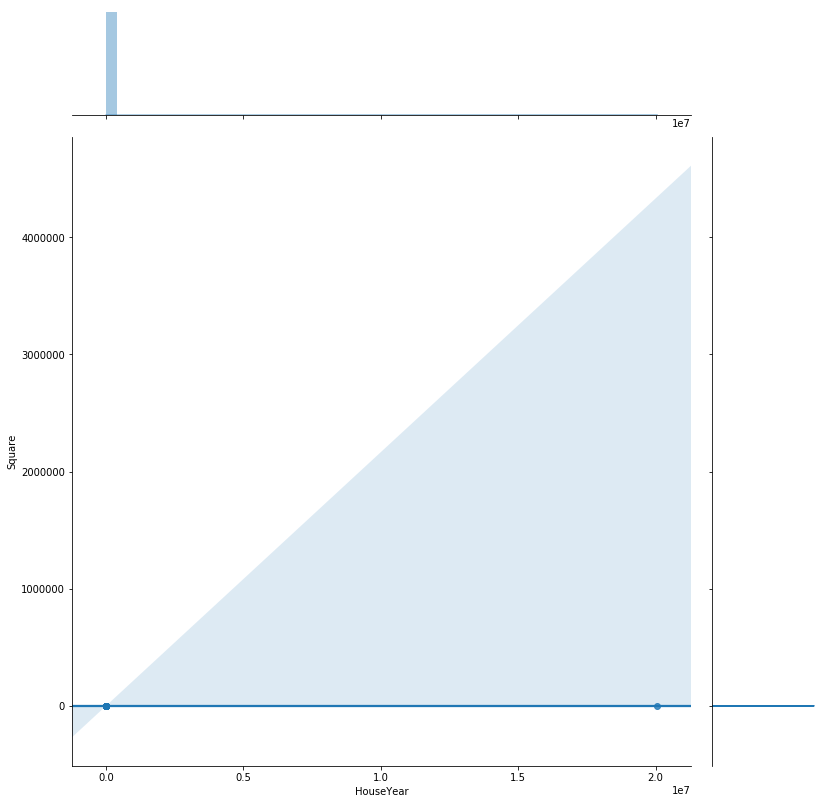

In [83]:
grid = sns.jointplot(df_num_features['HouseYear'], df_num_features['Square'], kind='reg')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

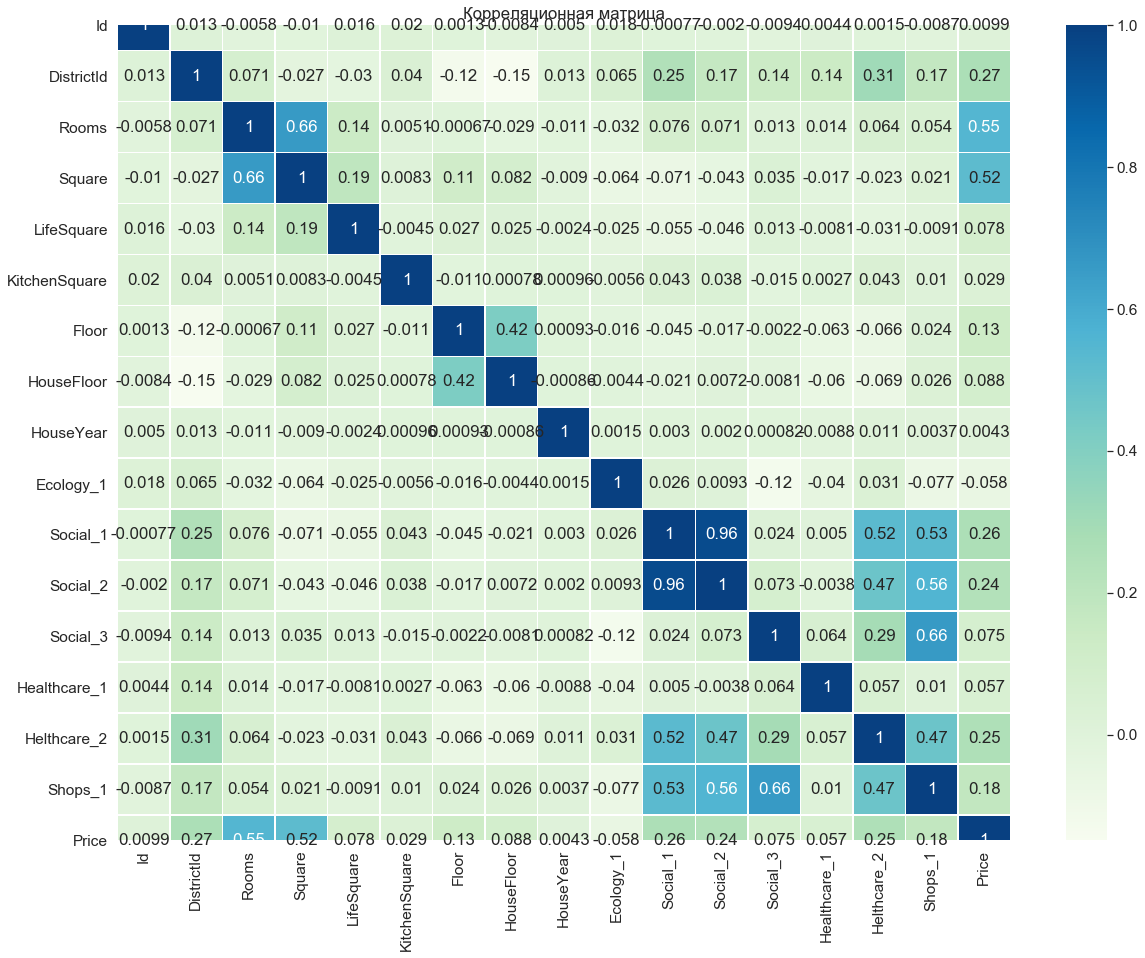

In [84]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)
sns.heatmap(df_num_features.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Корреляционная матрица')
plt.show()

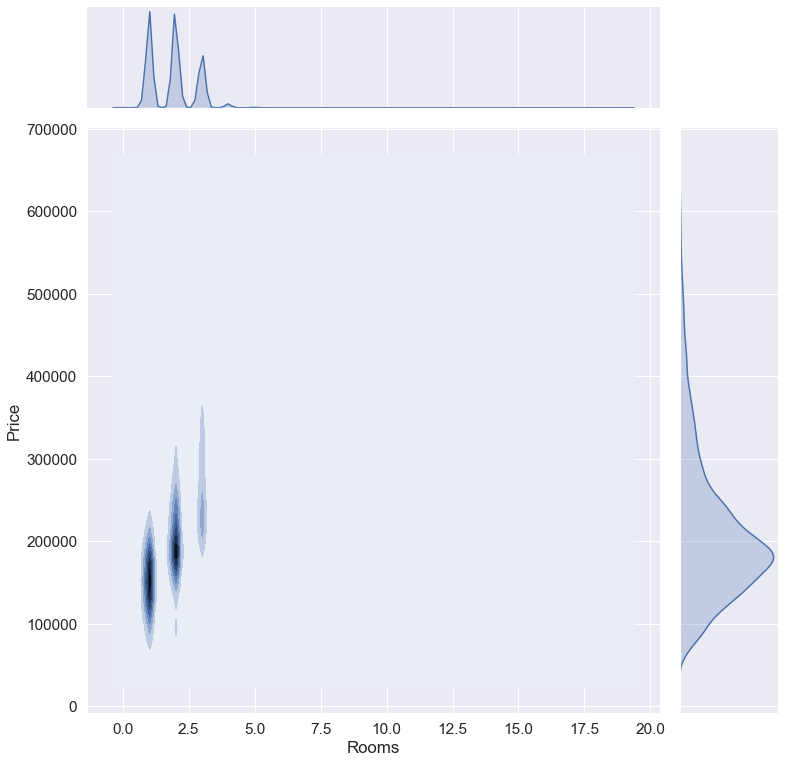

In [85]:
grid = sns.jointplot(df['Rooms'], df['Price'], kind='kde')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

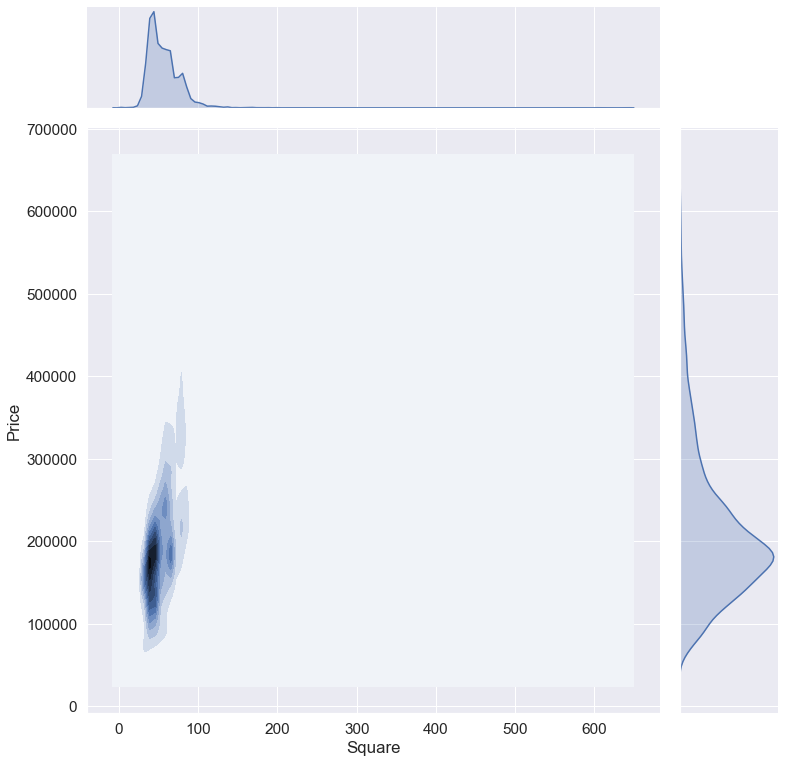

In [86]:
grid = sns.jointplot(df['Square'], df['Price'], kind='kde')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

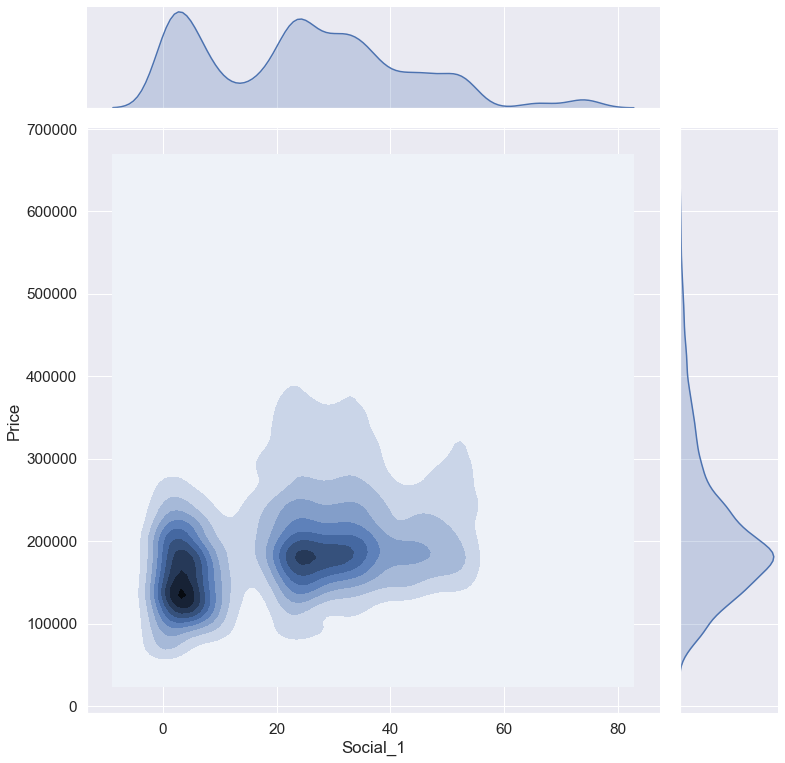

In [87]:
grid = sns.jointplot(df['Social_1'], df['Price'], kind='kde')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

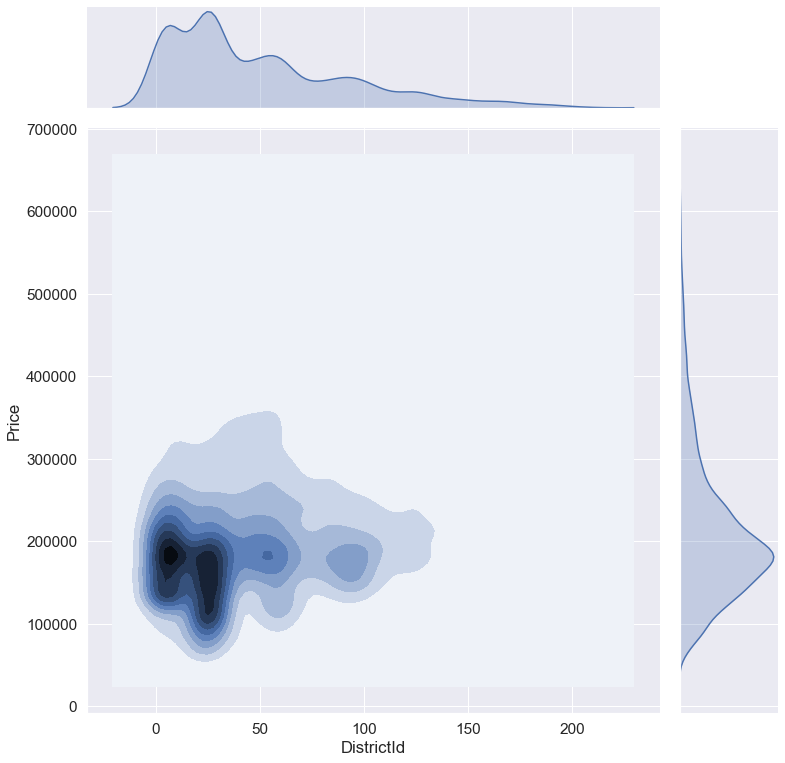

In [88]:
grid = sns.jointplot(df['DistrictId'], df['Price'], kind='kde')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

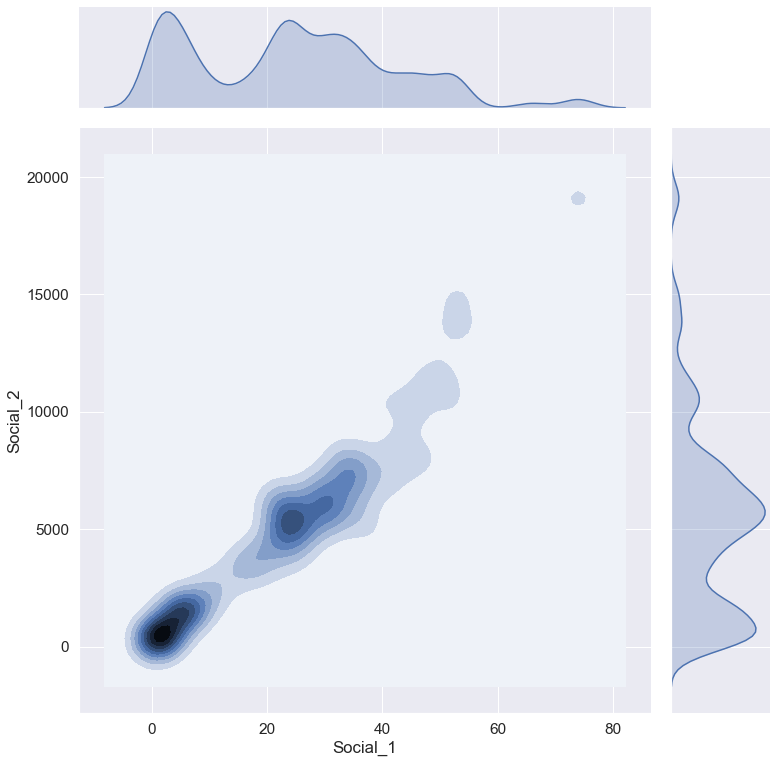

In [89]:
grid = sns.jointplot(df['Social_1'], df['Social_2'], kind='kde')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

### Отбор признаков

In [90]:
df_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

In [91]:
feature_names = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1']
target_name = 'Price'

In [92]:
df_train = df_train[feature_names + [target_name]]
df_train.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
7885   0           0      1  109.144492   84.613939             15      6   
5549   2           2      1   34.472263   16.069376              5      5   
4808   5           5      3   57.607965   38.955672              5      3   
4447   6           6      1   42.466813   40.010160              1     14   
2684  10           6      3   75.888156   78.324716              1     11   

      HouseFloor  HouseYear  Ecology_1  Social_1  Social_2  Social_3  \
7885          15       2011   0.319809        25      4756        16   
5549          18       1969   0.000000        33      7425         1   
4808           9       1974   0.150818        16      3433         4   
4447          17       2014   0.243205         5      1564         0   
2684          17       2014   0.243205         5      1564         0   

      Healthcare_1  Helthcare_2  Shops_1          Price  
7885        2857.0            5        8  289034.391871  
5549         645.0            2        5  174548.966339  
4808        2643.0            4        5  258091.883679  
4447         540.0            0        0  127196.762031  
2684         540.0            0        0  218500.747041

### Стандартизация признаков

In [93]:
feature_names_for_stand = df_train[feature_names].select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_names_for_stand

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

In [94]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df_train[feature_names_for_stand])

In [95]:
stand_features

array([[-1.72541553, -1.15636855, -1.06078845, ...,  1.43664478,
         2.46430269,  0.78414926],
       [-1.72500391, -1.11048164, -1.06078845, ..., -0.53662771,
         0.4556332 ,  0.15994256],
       [-1.72438647, -1.04165127,  1.32166737, ...,  1.24574048,
         1.79474619,  0.15994256],
       ...,
       [ 1.73142211, -0.10096956, -1.06078845, ...,  0.29300313,
        -0.8834798 , -0.67233303],
       [ 1.73162792,  1.00031634,  1.32166737, ..., -1.0834704 ,
        -0.8834798 ,  0.36801146],
       [ 1.73183374, -0.65161251, -1.06078845, ...,  0.14224226,
         1.12518969, -0.04812634]])

In [96]:
df_train[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [97]:
df_train.head()

Id  DistrictId     Rooms    Square  LifeSquare  KitchenSquare  \
7885  0.993994   -0.032139  0.130439 -0.735405   -0.210183      -0.009569   
5549  0.186794    0.036691 -1.060788 -0.767280   -0.095620      -0.184643   
4808 -0.061416   -0.949877  1.321667  0.219895   -0.021306      -0.009569   
4447 -0.184698   -0.146856  1.321667  0.200469    0.080481      -0.009569   
2684 -0.805637   -0.651613  0.130439 -0.637773   -0.121900      -0.044584   

         Floor  HouseFloor  HouseYear  Ecology_1  Social_1  Social_2  \
7885 -0.863728   -0.089940  -0.010076  -0.824372 -0.039186  0.065103   
5549  0.471924    0.647998  -0.010041   2.119752  0.531208  0.427505   
4808  0.471924   -0.532703  -0.010046   0.094651 -0.951817 -0.840153   
4447 -0.672921   -0.532703  -0.010071  -0.695141 -0.039186 -0.243138   
2684 -0.863728   -1.123053  -0.010101  -0.990278  0.987523  0.573764   

      Social_3  Healthcare_1  Helthcare_2   Shops_1          Price  
7885 -0.127533      0.083365     0.455633  0.159943  289034.391871  
5549 -0.295384     -0.442960     0.455633  0.159943  174548.966339  
4808 -0.337347     -0.964824    -0.883480 -0.880402  258091.883679  
4447 -0.337347     -0.187826    -0.213923 -0.672333  127196.762031  
2684 -0.295384     -0.389435    -0.213923  0.159943  218500.747041

### Сохранение обучающего датасета

In [98]:
TRAIN_DATASET_PATH_ADD = 'df_train_add.csv'

In [99]:
TEST_DATASET_PATH_ADD = 'df_test_add.csv'

In [100]:
df_train.to_csv(TRAIN_DATASET_PATH_ADD, index=False, encoding='utf-8')

### Разбиение на train и test

In [101]:
X = df_train[feature_names]
y = df_train[target_name]

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Построение базовых моделей и выбор лучшей

**Linear Regression**

In [103]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [104]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

R2:	0.002
MAE:	69716.055
MSE:	8751456705.948


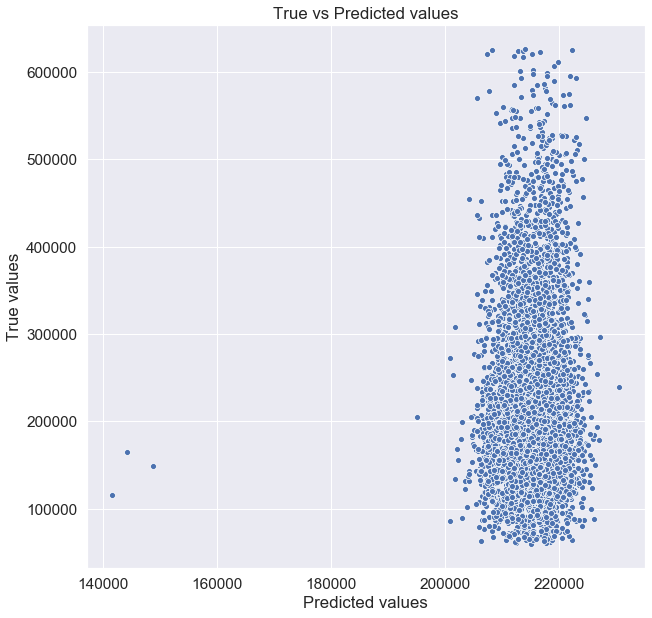

In [105]:
y_train_preds = lr_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	-0.006
MAE:	68298.5
MSE:	8373993228.822


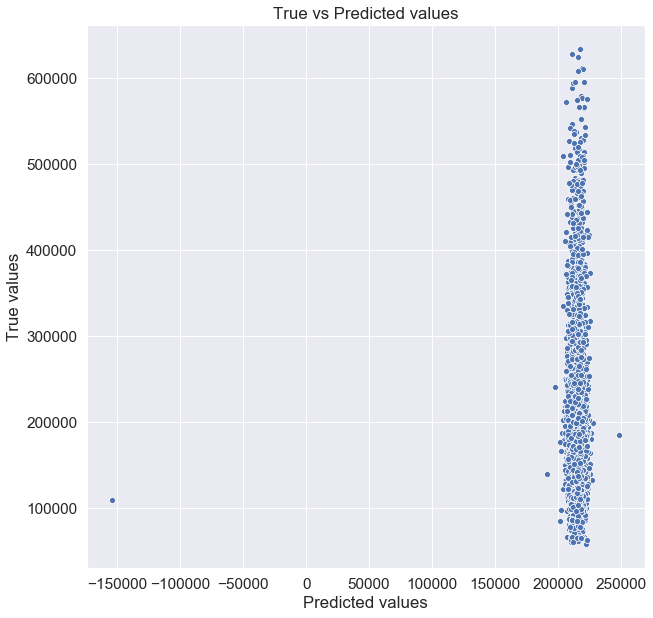

In [106]:
y_test_preds = lr_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [107]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

R2:	0.792
MAE:	30127.504
MSE:	1821089760.938


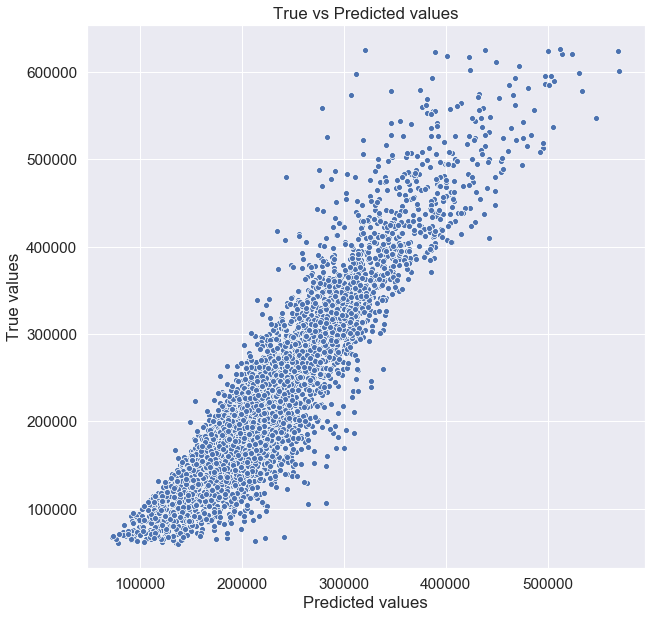

In [108]:
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	-0.179
MAE:	75161.699
MSE:	9816896981.776


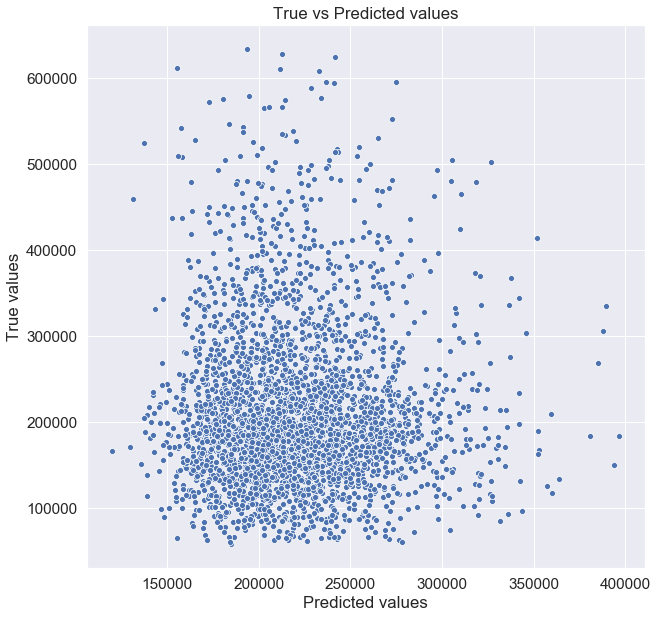

In [109]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [110]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.092
MAE:	66632.091
MSE:	7962847496.674


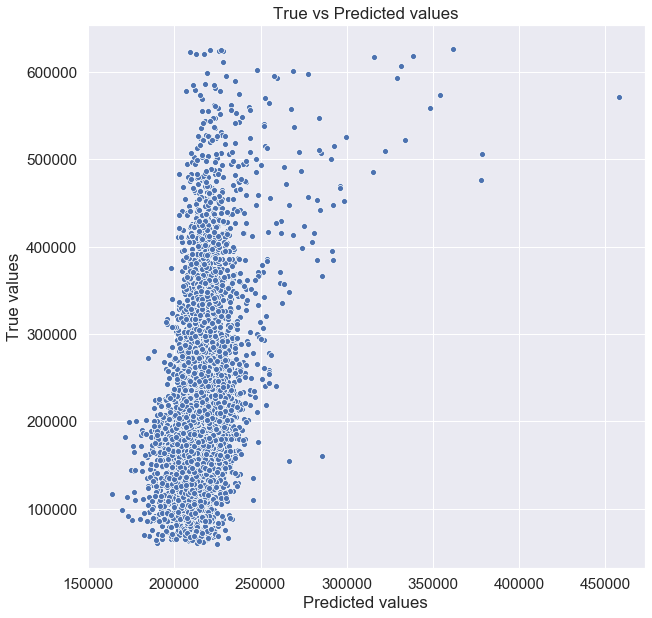

In [111]:
y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	-0.012
MAE:	68711.504
MSE:	8422531226.576


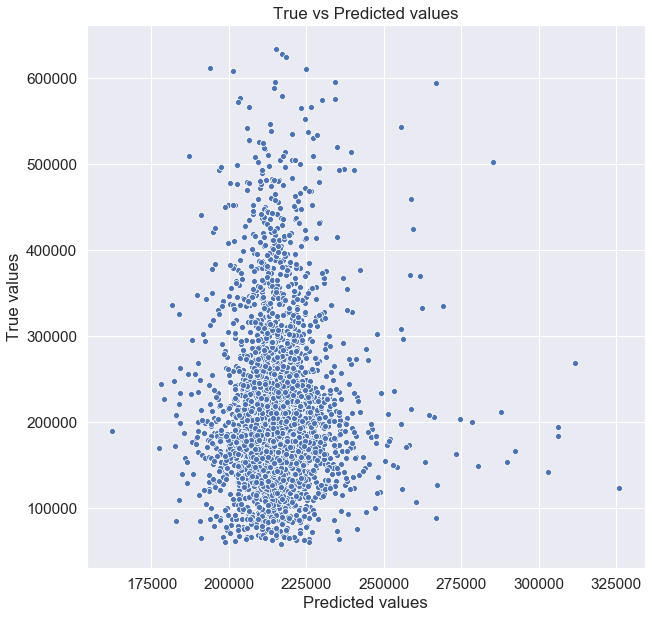

In [112]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [113]:
X_train.dtypes

Id               float64
DistrictId       float64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor            float64
HouseFloor       float64
HouseYear        float64
Ecology_1        float64
Social_1         float64
Social_2         float64
Social_3         float64
Healthcare_1     float64
Helthcare_2      float64
Shops_1          float64
dtype: object

In [114]:
y_train.dtypes

dtype('float64')

In [115]:
# clf = LogisticRegression()
# clf.fit(training_data_X, training_scores_Y)

lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)

# clf = LogisticRegression()
# clf.fit(training_data_X, training_scores_encoded)

In [116]:
log_r_model = LogisticRegression(solver="liblinear")
log_r_model.fit(X_train, y_train_encoded)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [117]:
? LogisticRegression

R2:	-5.117
MAE:	212013.933
MSE:	53640471150.518


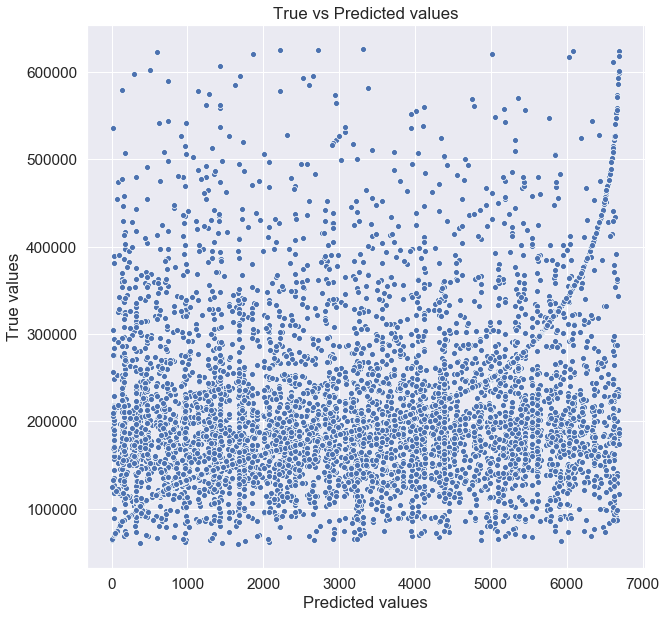

In [118]:
y_train_preds = log_r_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	-5.232
MAE:	208690.942
MSE:	51877206453.38


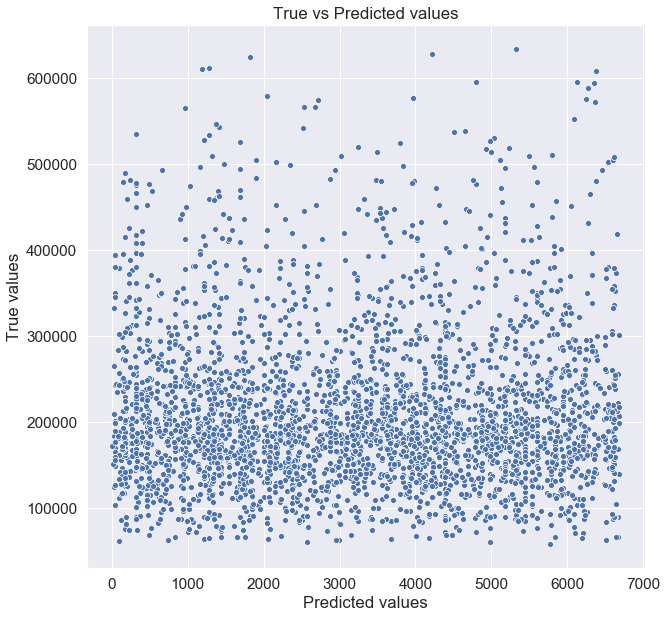

In [119]:
y_test_preds = log_r_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [120]:
DF_TEST_RESULT_DATASET_PATH = 'df_test_res.csv'

In [121]:
X_test = df_test[feature_names]

In [122]:
y_test_preds = rf_model.predict(X_test)

In [123]:
y_test_preds

array([252682.68622144, 295259.64750737, 318965.58450861, ...,
       369845.11846366, 369845.11846366, 321167.29642206])

In [124]:
df_res = pd.DataFrame({'Id':list(test['Id']),'Price':list(y_test_preds)})

In [125]:
df_res.to_csv(DF_TEST_RESULT_DATASET_PATH, index=False, encoding='utf-8')